## **Training** an EMNIST classifier

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision.datasets import EMNIST
import torchvision.transforms.functional as F
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, random_split

In [2]:
train_data = EMNIST(root='emnist_data/', split='byclass', download=True)
test_data = EMNIST(root='emnist_data/', split='byclass', download=True, train=False)

100%|██████████| 561753746/561753746 [00:17<00:00, 32353105.37it/s]


Extracting emnist_data/EMNIST/raw/gzip.zip to emnist_data/EMNIST/raw


Number of classes in dataset: 62
Unique labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
7


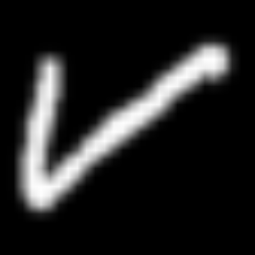

In [3]:
# This cell is for demo purposes. feel free to remove it if you want.
print('Number of classes in dataset:', len(train_data.classes))
print('Unique labels:', train_data.classes)

demo_img, demo_label = train_data[10]

print(demo_label)
torchvision.transforms.functional.resize(demo_img, (255, 255))

In [4]:
# Transformations for the EMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the datasets
train_data = EMNIST(root='emnist_data/', split='byclass', train=True, download=True, transform=transform)
test_data = EMNIST(root='emnist_data/', split='byclass', train=False, download=True, transform=transform)

# Define the size of the subset as a fraction of the original dataset
subset_fraction = 0.1 ## You can play with this to get a bigger or smaller subset

# Create indices for the training subset
train_indices = np.random.choice(len(train_data), int(len(train_data) * subset_fraction), replace=False)

# Create the training subset
train_subset = Subset(train_data, train_indices)


# For the test set, you can do the same or use the full test set
test_indices = np.random.choice(len(test_data), int(len(test_data) * subset_fraction), replace=False)
test_subset = Subset(test_data, test_indices)


# Check the size of the subset
print(f"Training subset size: {len(train_subset)}")
print(f"Test subset size: {len(test_subset)}")

# Define the DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

Training subset size: 69793
Test subset size: 11632


In [5]:
class FirstNN(nn.Module):
    def __init__(self, num_inp, num_hidden1, num_hidden2, num_out):
        super(FirstNN, self).__init__()

        self.layer_1 = nn.Linear(num_inp, num_hidden1)
        self.layer_2 = nn.Linear(num_hidden1, num_hidden2)
        self.layer_3 = nn.Linear(num_hidden2, num_out)

        self.ReLU = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        z1 = self.layer_1(x)
        a1 = self.ReLU(z1)
        z2 = self.layer_2(a1)
        a2 = self.ReLU(z2)
        z3 = self.layer_3(a2)
        a3 = self.softmax(z3)
        return a3

In [6]:
class SecondNN(nn.Module):
    def __init__(self, num_inp, num_hidden1, num_hidden2, num_hidden3, num_hidden4, num_out):
        super(SecondNN, self).__init__()


        self.layer_1 = nn.Linear(num_inp, num_hidden1)
        self.layer_2 = nn.Linear(num_hidden1, num_hidden2)
        self.layer_3 = nn.Linear(num_hidden2, num_hidden3)
        self.layer_4 = nn.Linear(num_hidden3, num_hidden4)
        self.layer_5 = nn.Linear(num_hidden4, num_out)

        self.ReLU = nn.ReLU()
        self.leakyReLU = nn.LeakyReLU()
        self.sigmod = nn.Sigmoid()
        self.log_sigmod = nn.LogSigmoid()
        self.Tanh = nn.Tanh()
        self.Thshold= nn.Threshold(0.1, 2)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        z1 = self.layer_1(x)
        a1 = self.ReLU(z1)
        z2 = self.layer_2(a1)
        a2 = self.log_sigmod(z2)
        z3 = self.layer_3(a2)
        a3 = self.leakyReLU(z3)
        z4 = self.layer_4(a3)
        a4 = self.Tanh(z4)
        z5 = self.layer_5(a4)
        a5 = self.softmax(z5)
        return a5

In [ ]:
num_epochs = 10
lr = 1e-3

device = 'cuda' if torch.cuda.is_available() else 'cpu'  # checks if machine supports cuda and if it does, we use that, otherwise cpu

train_losses = []
val_losses = []


model = SecondNN(28*28, 512, 256, 200, 128, 62)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()  # multi-class

model.to(device)  # we need to send all input tensors as well as our model to this device. by default they are on cpu

print(f'Using device {device}')

Using device cpu


In [ ]:
%%time
for epoch_no in range(num_epochs):

  model.train()  # convert to train model.

  epoch_weighted_loss = 0

  for batch_X, batch_y in train_loader:

    batch_X = batch_X.view(-1, 28*28).to(device)  # convert to [N, 28*28] shape where N is batch_size
    batch_y = batch_y.to(device)

    batch_y_probs = model(batch_X)

    loss = criterion(batch_y_probs, batch_y)

    optimizer.zero_grad()  # need to clear out gradients from previous batch
    loss.backward()  # calculate new gradients
    optimizer.step()  # update weights

    epoch_weighted_loss += (len(batch_y)*loss.item())

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
  train_losses.append(epoch_loss)


  # Validation time

  model.eval()  # take model to evaluation mode. turn off train-only layers
  correctly_labelled = 0

  with torch.no_grad():  #  to make model not track gradients

    val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in test_loader:

      val_batch_X = val_batch_X.view(-1, 28*28).to(device)
      val_batch_y = val_batch_y.to(device)

      val_batch_y_probs = model(val_batch_X)

      loss = criterion(val_batch_y_probs, val_batch_y)
      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  # convert probailities to labels by picking the label (index) with the highest prob

      correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item() converts tensor to float/int/list

  val_epoch_loss = val_epoch_weighted_loss/len(test_loader.dataset)
  val_losses.append(val_epoch_loss)

  print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')

print(f'Training complete on device {device}. Change device variable and run again to see the difference.')
# Im create two NN architecture the best one is the second one
# And the best hyperparameters I define it in above cell

Epoch: 0, train_loss=3.7888831096429065, val_loss=3.698520463959223. labelled 5317/11632 correctly (45.71011004126547% accuracy)
Epoch: 1, train_loss=3.691325133278591, val_loss=3.6854716304899737. labelled 5456/11632 correctly (46.9050894085282% accuracy)
Epoch: 2, train_loss=3.6328124228102214, val_loss=3.598214981808459. labelled 6471/11632 correctly (55.63101788170564% accuracy)
Epoch: 3, train_loss=3.579794171119753, val_loss=3.5555898726724364. labelled 6972/11632 correctly (59.93810178817056% accuracy)
Epoch: 4, train_loss=3.537100610646537, val_loss=3.512216692941553. labelled 7495/11632 correctly (64.43431911966988% accuracy)
Epoch: 5, train_loss=3.504951815758682, val_loss=3.501580583672084. labelled 7606/11632 correctly (65.38858321870703% accuracy)
Epoch: 6, train_loss=3.4880364687982213, val_loss=3.4762588924686058. labelled 7917/11632 correctly (68.06224209078404% accuracy)
Epoch: 7, train_loss=3.4675357563709177, val_loss=3.4636296832413915. labelled 8050/11632 correctly

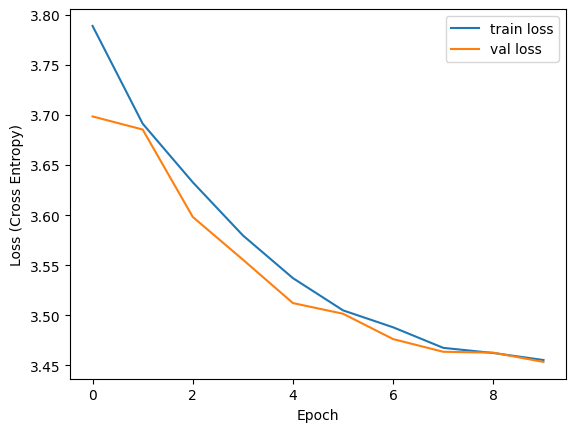

In [ ]:
# visualize the validation results
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.show()